**Prepping**

In [26]:
import os
from dotenv import load_dotenv
import openai
import csv
import pandas as pd
from openai import OpenAI
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [27]:
df = pd.read_csv("IMDB Dataset.csv")

In [28]:
df_small = df.iloc[200:300]

In [29]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("No OpenAI API key found. Check your .env file.")

In [30]:
openai.api_key = openai_api_key

In [31]:
client = OpenAI()

**Automatically Generate Prompt Variations**

In [35]:
def generate_prompt_variations():
   
    messages = [
        {"role": "user", "content": """Generate a good variation of the following instruction for a sentiment analysis task: Your task is to determine the sentiment of a movie review. Give your answer as either "positive" or "negative".
        The Variation has to inlcude the following:
         - Output only "positive" or "negative" in a single word 
         - Feel free to change the wording and the lenght of the prompt 
        Every variation has to end with the following: Review: ```{review_text}```
        Make sure to have that exact same ending in every variation.
         Do not ouput anything else but the prompt variation.
         """}
    ]

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0.8, # Change this for more crazy variations
        max_tokens=500,  
        n=4, # Change this to generate more variations
    )

    variations = [response.choices[i].message.content.strip() for i in range(len(response.choices))]

    return variations

prompt_variations = generate_prompt_variations()
# Print all prompts for debugging purposes
# for idx, prompt in enumerate(prompt_variations, start=1):
   # print(f"Prompt {idx}:\n{prompt}\n{'-'*60}\n")

**Test Generated Prompts**

In [33]:
# Define the analysis function
def get_completion_from_messages(prompt_template, review_text, model="gpt-3.5-turbo", temperature=0):
    formatted_prompt = prompt_template.format(review_text=review_text)
    
    response = client.chat.completions.create(
        model=model,
        messages=[{
            "role": "user",
            "content": formatted_prompt
        }],
        temperature=temperature,
    )
    
    return response.choices[0].message.content.strip().lower()

In [ ]:
# Loop through all variations and store the results in the dataframe
for idx, prompt_template in enumerate(prompt_variations, start=1):
    column_name = f'predicted_sentiment_{idx}'
    
    for index, row in df_small.iterrows():
        review = row['review']
        response = get_completion_from_messages(prompt_template, review)
        df_small.at[index, column_name] = response.strip().lower()

In [ ]:
# Get performance metrics
f1_scores = {}  # Define the f1_scores dictionary
for idx in range(1, len(prompt_variations) + 1):
    column_name = f'predicted_sentiment_{idx}'
    predicted_labels = df_small[column_name]
    
    true_labels = df_small['sentiment']
    report_dict = classification_report(true_labels, predicted_labels, target_names=['negative', 'positive'], output_dict=True)
    
    
    f1_score_negative = report_dict['negative']['f1-score']
    f1_score_positive = report_dict['positive']['f1-score']
    f1_score_average = report_dict['macro avg']['f1-score']  # or 'weighted avg' for weighted average
    
    
    f1_scores[column_name] = {
        'negative': f1_score_negative,
        'positive': f1_score_positive,
        'average': f1_score_average
    }

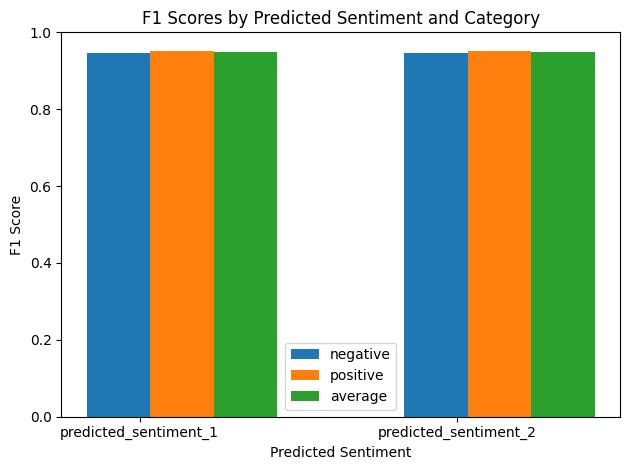

In [ ]:
# Plot this shiiiiiit
categories = ['negative', 'positive', 'average']
n_categories = len(categories)
n_predictions = len(f1_scores)

fig, ax = plt.subplots()


index = np.arange(n_predictions)
bar_width = 0.2


for i, category in enumerate(categories):
    scores = [f1_scores[prediction][category] for prediction in f1_scores]
    ax.bar(index + i * bar_width, scores, bar_width, label=category)


ax.set_xlabel('Predicted Sentiment')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Predicted Sentiment and Category')
ax.set_xticks(index + bar_width / n_categories)
ax.set_xticklabels(list(f1_scores.keys()))
ax.legend()


plt.tight_layout()


plt.show()